# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


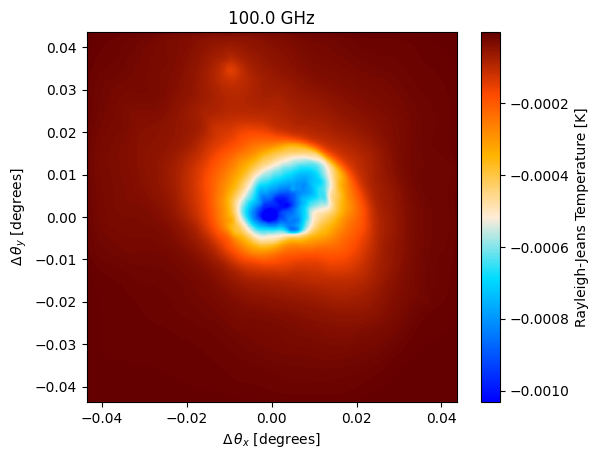

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

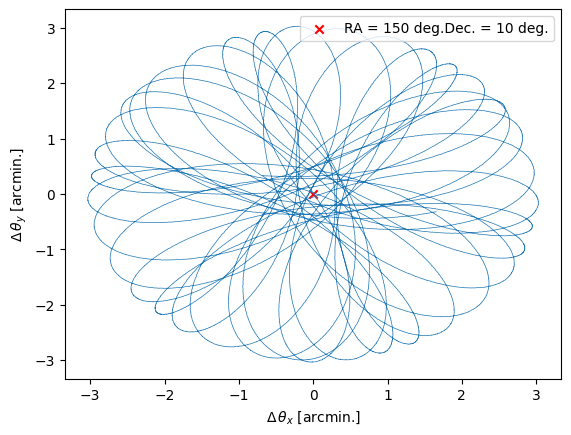

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-18 12:16:15.943 INFO: Initialized base in 1639 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
2024-10-18 12:16:22.051 INFO: Initialized atmosphere in 6093 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


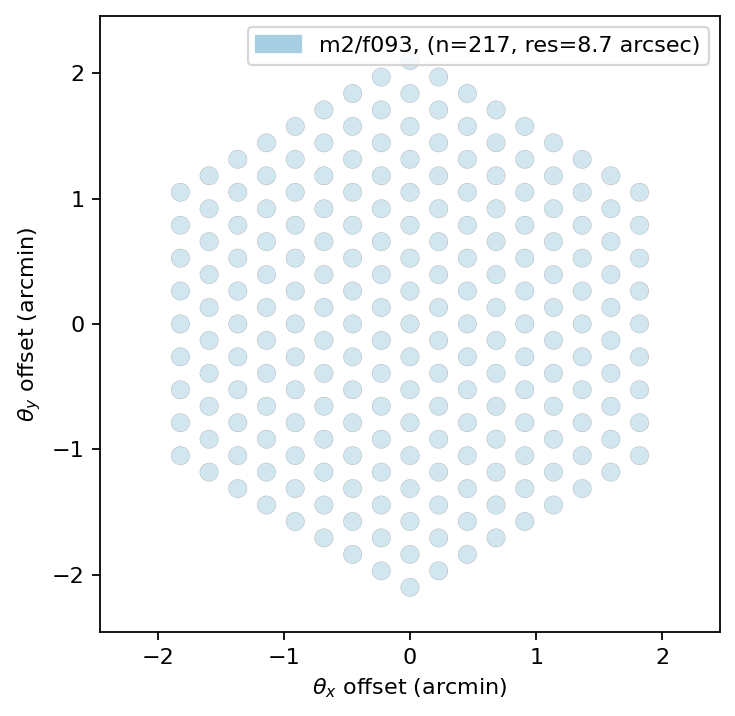

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.97068631e-04, -1.92782668e-04, -1.90222653e-04, ...,
         4.74082993e-04,  4.76986418e-04,  4.81362248e-04],
       [-2.46187703e-04, -2.41901927e-04, -2.39341980e-04, ...,
         4.28736301e-04,  4.31639621e-04,  4.36015215e-04],
       [-1.21878437e-04, -1.17592516e-04, -1.15032517e-04, ...,
         5.49960982e-04,  5.52864392e-04,  5.57240190e-04],
       ...,
       [ 1.20693772e-04,  1.24981269e-04,  1.27541843e-04, ...,
         7.60978490e-04,  7.63882769e-04,  7.68260520e-04],
       [-4.05637593e-04, -4.01349799e-04, -3.98789117e-04, ...,
         2.29832560e-04,  2.32736942e-04,  2.37114923e-04],
       [-7.46447954e-04, -7.42162109e-04, -7.39602137e-04, ...,
        -7.18783389e-05, -6.89750366e-05, -6.45994811e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


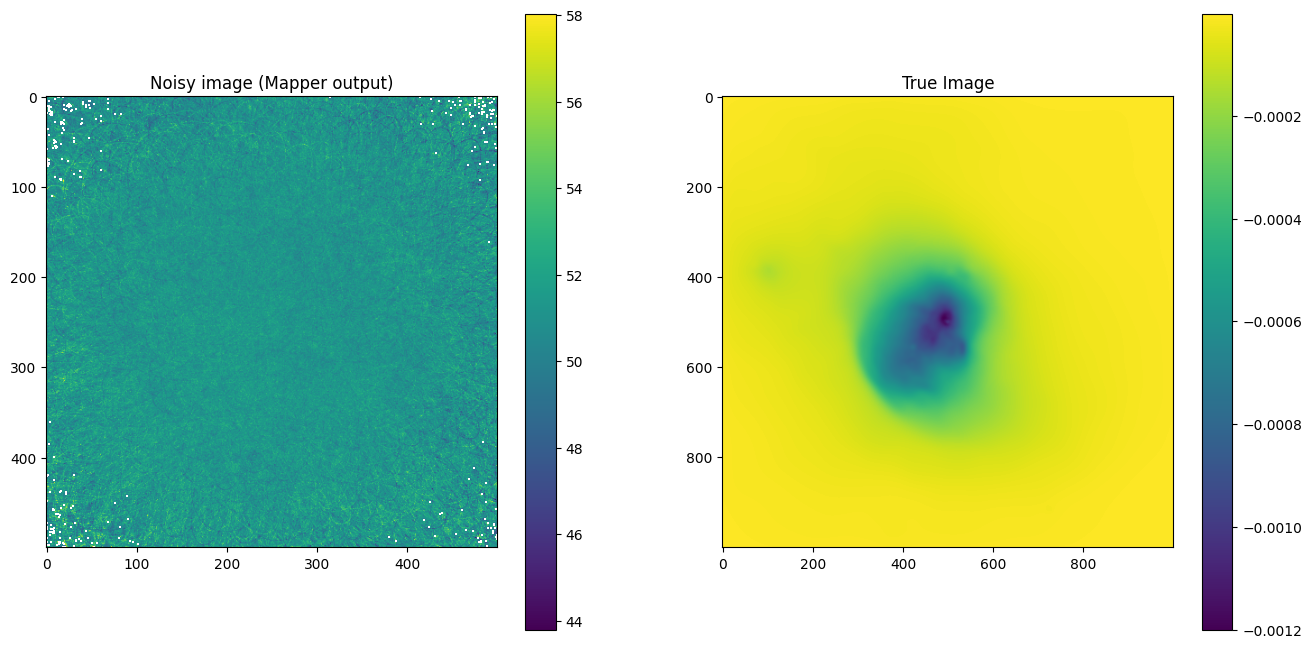

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-18 12:16:36.780 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-18 12:16:36.781 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Prepare noised input TODs:

Noise stddev: 0.0002516373450495108


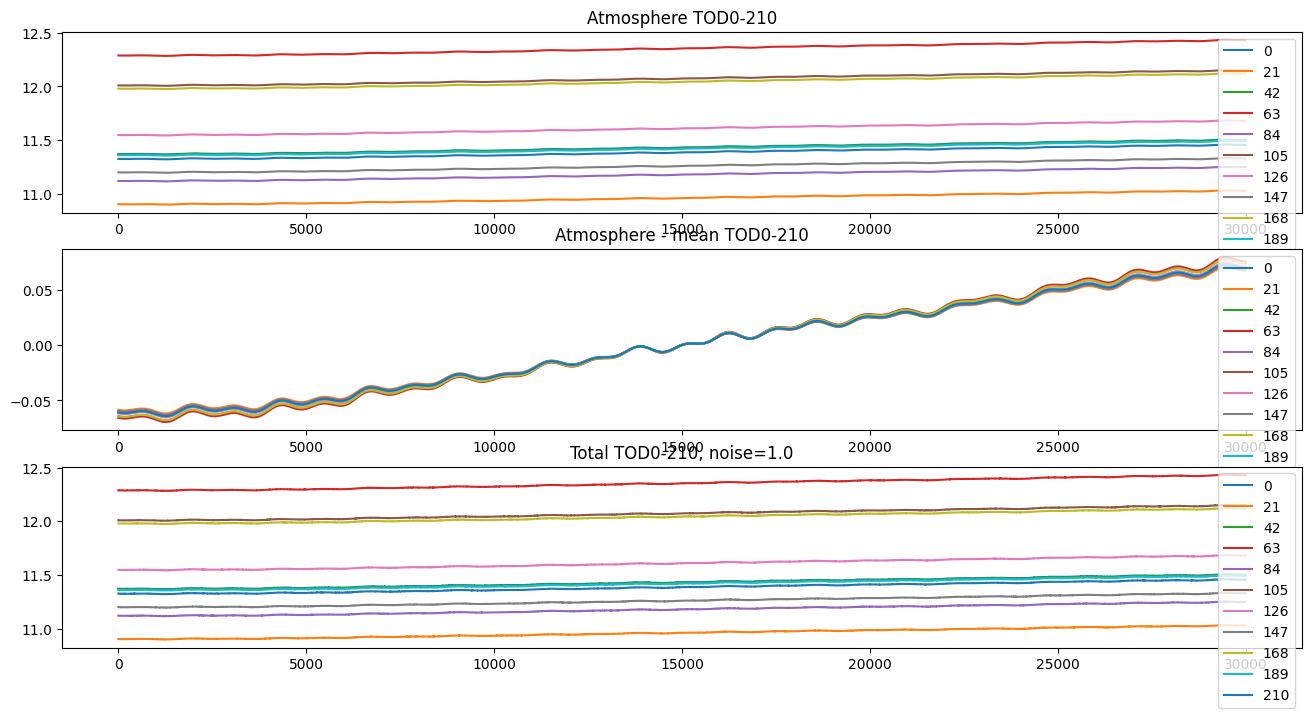

In [7]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods_atmos = tod_truthmap.get_field('atmosphere')

# Add n TODs for atmos:
# n = 1
# n = 2
# n = 10
# n = 100
n = jax_tods_atmos.shape[0]

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
# noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
# # noised_jax_tod[:n] = np.float64(jax_tods_atmos[:n])

noised_jax_tod = np.float64(jax_tods_atmos)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean(), label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'Atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere - mean TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

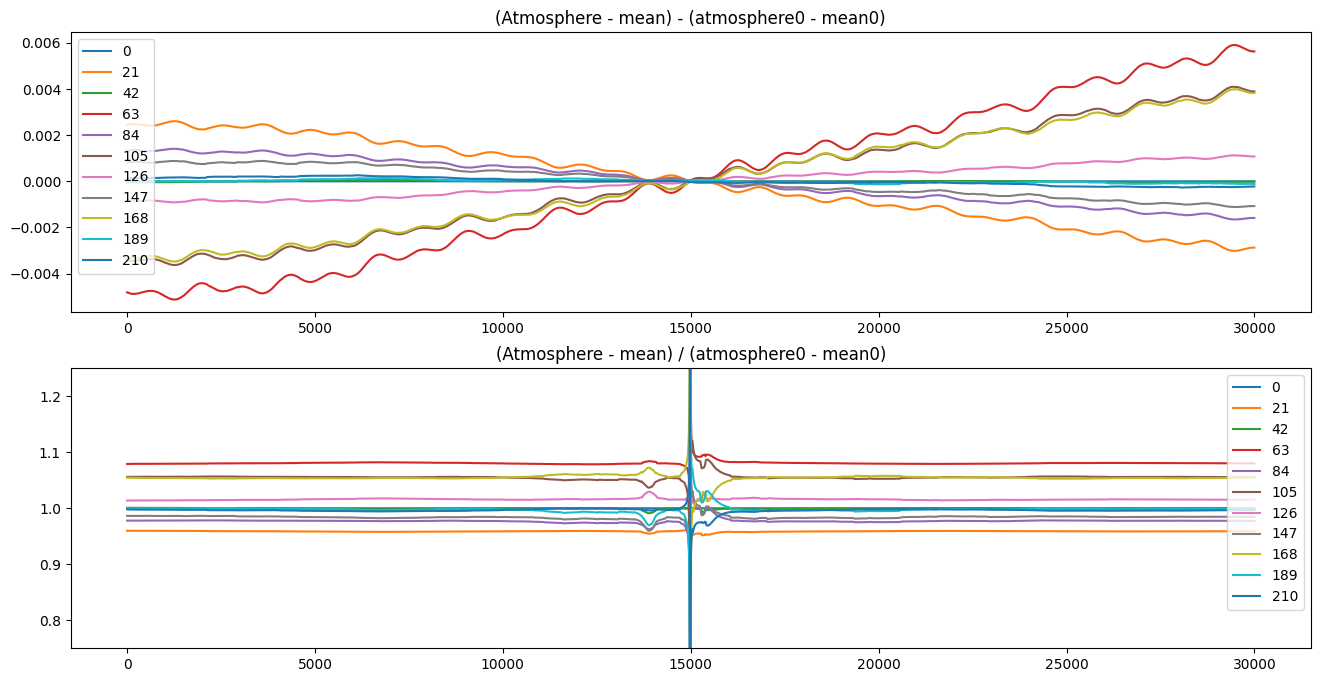

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    axes[0].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean() - (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    axes[1].plot( (jax_tods_atmos[i] - jax_tods_atmos[i].mean()) / (jax_tods_atmos[0] - jax_tods_atmos[0].mean()), label=i)
    
axes[0].title.set_text(f'(Atmosphere - mean) - (atmosphere0 - mean0)')
axes[0].legend()
axes[1].title.set_text(f'(Atmosphere - mean) / (atmosphere0 - mean0)')
axes[1].legend()
axes[1].set_ylim([0.75, 1.25])

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [10]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [11]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [12]:
# padding_atmos = 2000
# padding_atmos = 5000
padding_atmos = 10000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos[0].mean().compute(), offset_std=(0.0005, 0.001))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0002, 0.0001))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.002, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.003), 
    # fluctuations=(0.001, 0.0005),
    fluctuations=(0.002, 0.001),
    # loglogavgslope=(-3, 0.5), 
    # loglogavgslope=(-2, 0.5), 
    loglogavgslope=(-2.5, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)
gp_tod

# Old: default CFM:
# cfm_tod = jft.CorrelatedFieldMaker("")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# # init params for each TOD:
# gps_tods = []
# for i in range(n):
#     cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
#     # cfmi.set_amplitude_total_offset(**cf_zm_tod)
#     cfmi._azm = cfm_tod._azm
#     cfmi._offset_mean = cfm_tod._offset_mean
#     cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

#     cfmi._fluctuations.append(cfm_tod._fluctuations[0])
#     cfmi._target_grids.append(cfm_tod._target_grids[0])
#     cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
#     gps_tods.append(cfmi.finalize())
# gps_tods

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x1467977db9c0>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x146794386520>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x146794386520>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x146794386520>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

# Define offset NormalPrior:

deviation_mean: 3.24344531434106e-15
deviation std: 0.5741423146936657
deviation_truth mean: -7.394857281560941e-15
deviation_truth std: 0.5741422113958676


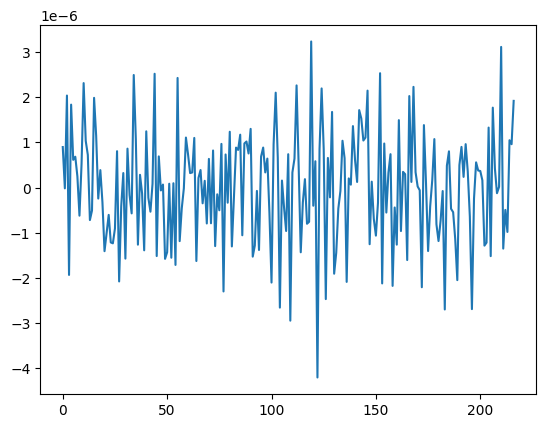

In [31]:
deviation_truth = (jax_tods_atmos - jax_tods_atmos.mean()).compute()
deviation = noised_jax_tod - noised_jax_tod.mean()

print("deviation_mean:", deviation.mean())
print("deviation std:", deviation.std())
print("deviation_truth mean:", deviation_truth.mean())
print("deviation_truth std:", deviation_truth.std())

offset_tod = jnp.float64(deviation.mean(axis=1)[:n])
offset_tod_truth = jnp.float64(deviation_truth.mean(axis=1)[:n])

plt.plot(offset_tod - offset_tod_truth)

# for testing:
# offset_tod = offset_tod_truth

In [32]:
# offset_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
# offset_tod = jft.NormalPrior(**offset_dict, name='offset')

# offset_tod

# OLD Signal model:

In [33]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

# signal_response_tod = Signal_TOD(gps_tods)

# CFM - TOD

In [34]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod, offset_tod):
        self.gp_tod = gp_tod
        self.offset_tod = offset_tod
        # super().__init__(init = self.gp_tod.init | self.offset_tod.init, domain = self.gp_tod.domain | self.offset_tod.domain )
        super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x)

        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod(x)[:, jax.numpy.newaxis]
        return res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod[:, jax.numpy.newaxis]

signal_response_tod = Signal_TOD(gp_tod, offset_tod)

In [35]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
print(noised_jax_tod.shape)
# truth = noised_jax_tod[:, 100:-100]
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(217, 30000)


In [36]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x146794386520>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x146794386520>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x146794386520>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x146794386520>, primals=ShapeW

# Draw Prior sample

(217, 30000)


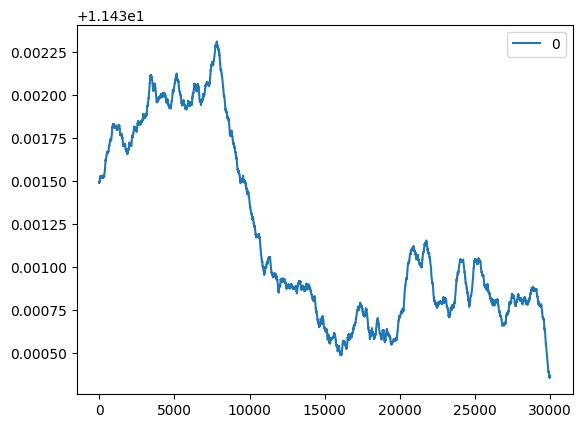

In [37]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [38]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:3.080215e+04 ➽:8.680003e+02
M: Iteration 1 ⛰:+1.499707e+09 Δ⛰:8.833049e+10
M: →:0.5 ↺:False #∇²:12 |↘|:1.837972e+03 ➽:8.680003e+02
M: Iteration 2 ⛰:+9.124608e+08 Δ⛰:5.872465e+08
M: →:1.0 ↺:False #∇²:18 |↘|:4.991948e+03 ➽:8.680003e+02
M: Iteration 3 ⛰:+6.144055e+08 Δ⛰:2.980552e+08
M: →:1.0 ↺:False #∇²:24 |↘|:5.833171e+03 ➽:8.680003e+02
M: Iteration 4 ⛰:+3.173556e+08 Δ⛰:2.970500e+08
M: →:1.0 ↺:False #∇²:30 |↘|:2.863059e+03 ➽:8.680003e+02
M: Iteration 5 ⛰:+2.667561e+08 Δ⛰:5.059947e+07
M: →:1.0 ↺:False #∇²:36 |↘|:4.260246e+03 ➽:8.680003e+02
M: Iteration 6 ⛰:+2.236943e+08 Δ⛰:4.306186e+07
M: →:1.0 ↺:False #∇²:42 |↘|:2.716371e+03 ➽:8.680003e+02
M: Iteration 7 ⛰:+1.902158e+08 Δ⛰:3.347850e+07
M: →:1.0 ↺:False #∇²:48 |↘|:3.842050e+03 ➽:8.680003e+02
M: Iteration 8 ⛰:+1.618340e+08 Δ⛰:2.838171e+07
M: →:1.0 ↺:False #∇²:54 |↘|:2.704823e+03 ➽:8.680003e+02
M: Iteration 9 ⛰:+1.397752e+08 Δ⛰:2.205888e+07
M: →:1.0 ↺:False #∇²:63 |↘|:2.515607e+04 ➽:8.6

In [39]:
samples.pos

Vector(
	{'combcf tod fluctuations': Array(0.2347436, dtype=float64),
	 'combcf tod loglogavgslope': Array(1.92033663, dtype=float64),
	 'combcf xi': Array([[  1.59529674,  31.21410759,  15.96625174, ...,  -6.71138344,
	        -14.74006431, -29.40124499],
	       [  2.39291692,  30.88470042,  16.16596899, ...,  -5.74053602,
	        -13.50350233, -28.47918276],
	       [  2.78953169,  34.41164624,  17.84034664, ...,  -6.62324114,
	        -15.32051971, -31.72125864],
	       ...,
	       [  3.23090228,  30.02009555,  15.99114889, ...,  -5.54922688,
	        -12.87338   , -27.10512698],
	       [  2.22903891,  30.69060447,  16.17935069, ...,  -6.0159214 ,
	        -13.90883933, -28.32466312],
	       [  3.01723395,  28.91711955,  15.19082149, ...,  -4.92040652,
	        -12.31624166, -26.06436646]], dtype=float64),
	 'combcf zeromode': Array(1.31907147, dtype=float64)}
)

In [40]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    # NEW model:
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    # OLD model:
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # offset per detector:
    # offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
    # print(f"\toffset: ({offset_results.mean()}, {offset_results.std()}), {offset_dict['mean']}, {offset_dict['std']}")
    # # residual offset:
    # offset_residuals = offset_results - jnp.float64(deviation.mean(axis=1)[:n].compute())
    # print(f"\toffset residuals: ({offset_residuals.mean()}, {offset_residuals.std()})")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.0019986336244589885, 0.002, 0.001
	loglogvarslope: -1.5398316841129418, -2.5, 0.5
	zeromode std (LogNormal): 0.00033356892992280756, 0.0002, 0.0001


(217, 30000)


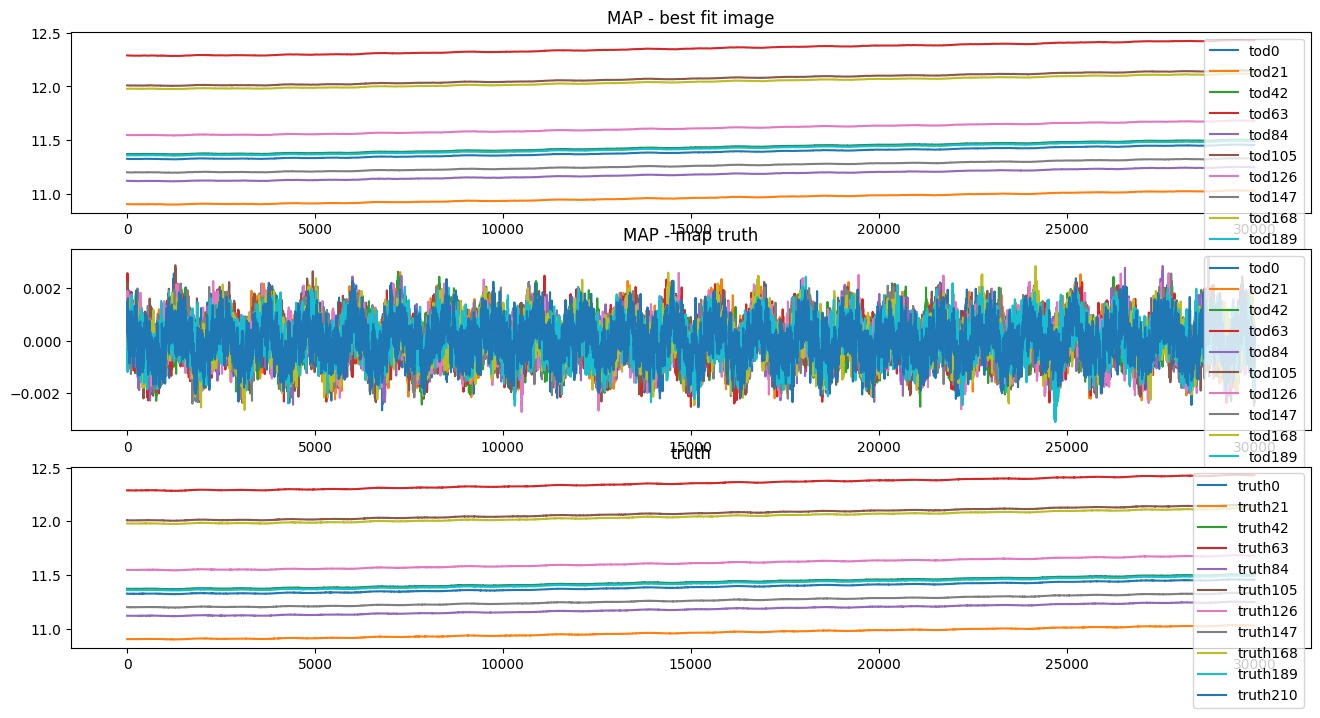

In [41]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [42]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+4.6148e+08 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+4.0424e+08 Δ⛰:5.7245e+07 ➽:8.6800e+01
SL: Iteration 2 ⛰:+3.6645e+08 Δ⛰:3.7786e+07 ➽:8.6800e+01
SL: Iteration 3 ⛰:+1.0991e+08 Δ⛰:2.5654e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+7.4670e+07 Δ⛰:3.5245e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+5.1105e+07 Δ⛰:2.3565e+07 ➽:8.6800e+01
SL: Iteration 6 ⛰:+3.5202e+07 Δ⛰:1.5903e+07 ➽:8.6800e+01
SL: Iteration 7 ⛰:+1.9494e+07 Δ⛰:1.5708e+07 ➽:8.6800e+01
SL: Iteration 8 ⛰:+1.6629e+07 Δ⛰:2.8652e+06 ➽:8.6800e+01
SL: Iteration 9 ⛰:+1.6582e+07 Δ⛰:4.7119e+04 ➽:8.6800e+01
SL: Iteration 10 ⛰:+1.3015e+07 Δ⛰:3.5672e+06 ➽:8.6800e+01
SL: Iteration 11 ⛰:+1.0938e+07 Δ⛰:2.0764e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+1.0797e+07 Δ⛰:1.4176e+05 ➽:8.6800e+01
SL: Iteration 13 ⛰:+8.8683e+06 Δ⛰:1.9283e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+8.1442e+06 Δ⛰:7.2414e+05 ➽:8.6800e+01
SL: Iteration 15 ⛰:+5.3684e+06 Δ⛰:2.7758e+06 ➽:8.6800e+01
SL: Iteration 16 ⛰:+5.3421e+06 Δ⛰:2.6359e+04 ➽:8.6800e+01
SL: 

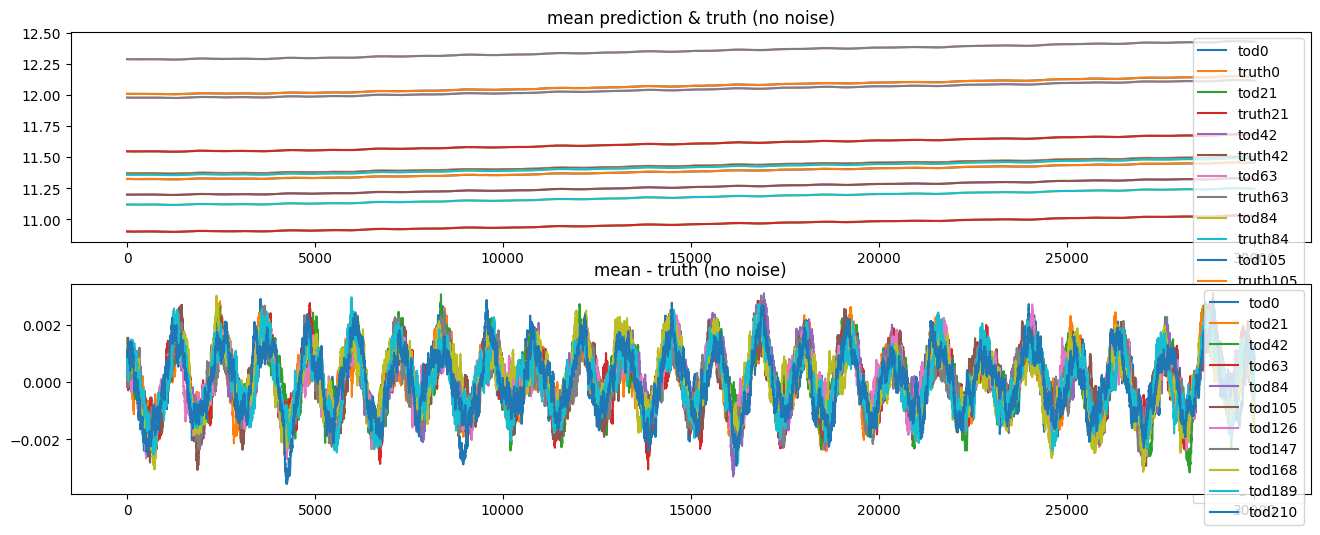

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+1.4330e+10 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+6.8014e+08 Δ⛰:1.3650e+10 ➽:8.6800e+01
SL: Iteration 2 ⛰:+4.5880e+08 Δ⛰:2.2135e+08 ➽:8.6800e+01
SL: Iteration 3 ⛰:+1.6680e+08 Δ⛰:2.9200e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+1.4224e+08 Δ⛰:2.4560e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+1.3810e+08 Δ⛰:4.1341e+06 ➽:8.6800e+01
SL: Iteration 6 ⛰:+9.4098e+07 Δ⛰:4.4005e+07 ➽:8.6800e+01
SL: Iteration 7 ⛰:+6.0953e+07 Δ⛰:3.3145e+07 ➽:8.6800e+01
SL: Iteration 8 ⛰:+3.9440e+07 Δ⛰:2.1512e+07 ➽:8.6800e+01
SL: Iteration 9 ⛰:+3.8618e+07 Δ⛰:8.2187e+05 ➽:8.6800e+01
SL: Iteration 10 ⛰:+3.8617e+07 Δ⛰:1.2758e+03 ➽:8.6800e+01
SL: Iteration 11 ⛰:+3.4260e+07 Δ⛰:4.3573e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+2.6068e+07 Δ⛰:8.1922e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+2.1042e+07 Δ⛰:5.0259e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+2.0968e+07 Δ⛰:7.4028e+04 ➽:8.6800e+01
SL: Iteration 15 ⛰:+1.7463e+07 Δ⛰:3.5046e+06 ➽:8.6800e+01
SL: Iteration 16 ⛰:+1.7449e+07 Δ⛰:1.3668e+04 ➽:8.6800e+01
SL: 

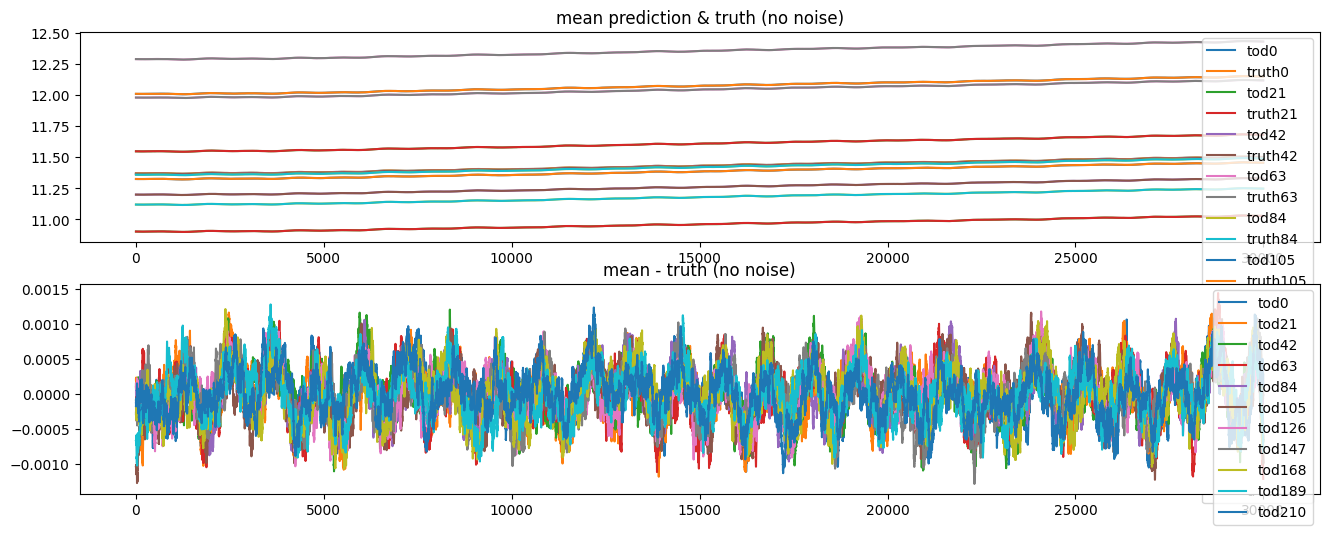

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+1.1602e+09 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+7.7010e+08 Δ⛰:3.9013e+08 ➽:8.6800e+01
SL: Iteration 2 ⛰:+4.9308e+08 Δ⛰:2.7702e+08 ➽:8.6800e+01
SL: Iteration 3 ⛰:+1.6221e+08 Δ⛰:3.3087e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+1.3221e+08 Δ⛰:2.9999e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+8.5281e+07 Δ⛰:4.6929e+07 ➽:8.6800e+01
SL: Iteration 6 ⛰:+8.4168e+07 Δ⛰:1.1132e+06 ➽:8.6800e+01
SL: Iteration 7 ⛰:+4.8058e+07 Δ⛰:3.6110e+07 ➽:8.6800e+01
SL: Iteration 8 ⛰:+2.6945e+07 Δ⛰:2.1113e+07 ➽:8.6800e+01
SL: Iteration 9 ⛰:+2.6875e+07 Δ⛰:7.0137e+04 ➽:8.6800e+01
SL: Iteration 10 ⛰:+2.6481e+07 Δ⛰:3.9421e+05 ➽:8.6800e+01
SL: Iteration 11 ⛰:+2.0328e+07 Δ⛰:6.1530e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+1.7676e+07 Δ⛰:2.6521e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+1.3163e+07 Δ⛰:4.5127e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+1.3158e+07 Δ⛰:4.6448e+03 ➽:8.6800e+01
SL: Iteration 15 ⛰:+1.2652e+07 Δ⛰:5.0682e+05 ➽:8.6800e+01
SL: Iteration 16 ⛰:+1.2255e+07 Δ⛰:3.9666e+05 ➽:8.6800e+01
SL: 

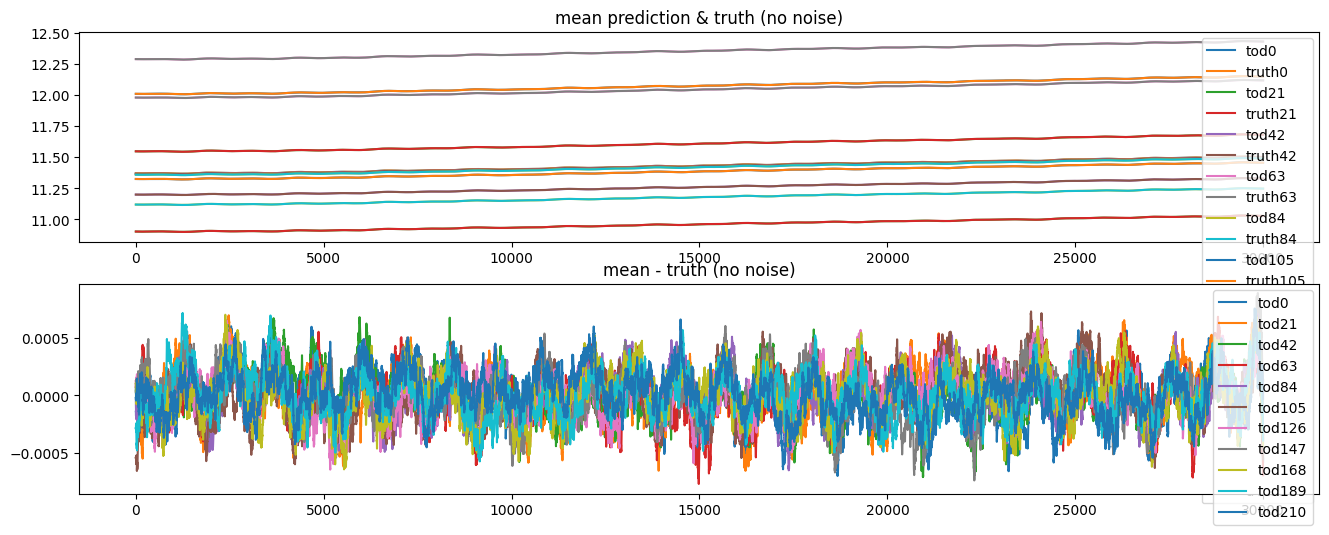

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+3.5808e+10 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+1.1857e+09 Δ⛰:3.4622e+10 ➽:8.6800e+01
SL: Iteration 2 ⛰:+5.2883e+08 Δ⛰:6.5683e+08 ➽:8.6800e+01
SL: Iteration 3 ⛰:+1.3018e+08 Δ⛰:3.9865e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+1.1276e+08 Δ⛰:1.7419e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+8.1007e+07 Δ⛰:3.1755e+07 ➽:8.6800e+01
SL: Iteration 6 ⛰:+7.5610e+07 Δ⛰:5.3971e+06 ➽:8.6800e+01
SL: Iteration 7 ⛰:+3.8749e+07 Δ⛰:3.6861e+07 ➽:8.6800e+01
SL: Iteration 8 ⛰:+2.1375e+07 Δ⛰:1.7374e+07 ➽:8.6800e+01
SL: Iteration 9 ⛰:+2.1311e+07 Δ⛰:6.3624e+04 ➽:8.6800e+01
SL: Iteration 10 ⛰:+2.1311e+07 Δ⛰:1.7243e+02 ➽:8.6800e+01
SL: Iteration 11 ⛰:+1.8674e+07 Δ⛰:2.6373e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+1.3822e+07 Δ⛰:4.8513e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+8.8263e+06 Δ⛰:4.9962e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+8.8244e+06 Δ⛰:1.8936e+03 ➽:8.6800e+01
SL: Iteration 15 ⛰:+8.5119e+06 Δ⛰:3.1254e+05 ➽:8.6800e+01
SL: Iteration 16 ⛰:+5.7149e+06 Δ⛰:2.7970e+06 ➽:8.6800e+01
SL: 

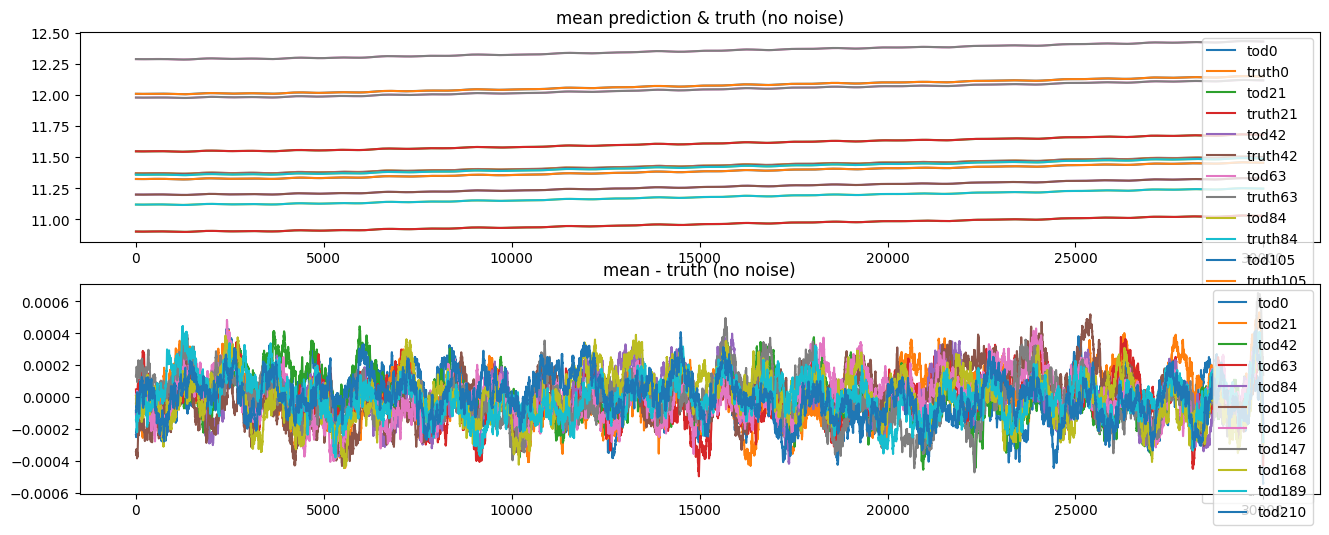

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+2.0087e+11 Δ⛰:inf ➽:8.6800e+01
SL: Iteration 1 ⛰:+4.4855e+08 Δ⛰:2.0042e+11 ➽:8.6800e+01
SL: Iteration 2 ⛰:+4.4545e+08 Δ⛰:3.0992e+06 ➽:8.6800e+01
SL: Iteration 3 ⛰:+1.0596e+08 Δ⛰:3.3949e+08 ➽:8.6800e+01
SL: Iteration 4 ⛰:+9.2324e+07 Δ⛰:1.3641e+07 ➽:8.6800e+01
SL: Iteration 5 ⛰:+8.5945e+07 Δ⛰:6.3789e+06 ➽:8.6800e+01
SL: Iteration 6 ⛰:+6.5626e+07 Δ⛰:2.0319e+07 ➽:8.6800e+01
SL: Iteration 7 ⛰:+2.9433e+07 Δ⛰:3.6193e+07 ➽:8.6800e+01
SL: Iteration 8 ⛰:+1.3465e+07 Δ⛰:1.5968e+07 ➽:8.6800e+01
SL: Iteration 9 ⛰:+1.3459e+07 Δ⛰:5.1671e+03 ➽:8.6800e+01
SL: Iteration 10 ⛰:+1.3459e+07 Δ⛰:1.1977e+02 ➽:8.6800e+01
SL: Iteration 11 ⛰:+1.1645e+07 Δ⛰:1.8141e+06 ➽:8.6800e+01
SL: Iteration 12 ⛰:+8.5258e+06 Δ⛰:3.1195e+06 ➽:8.6800e+01
SL: Iteration 13 ⛰:+4.7394e+06 Δ⛰:3.7864e+06 ➽:8.6800e+01
SL: Iteration 14 ⛰:+4.7393e+06 Δ⛰:9.0109e+01 ➽:8.6800e+01
SL: Iteration 15 ⛰:+4.2445e+06 Δ⛰:4.9481e+05 ➽:8.6800e+01
SL: Iteration 16 ⛰:+4.0556e+06 Δ⛰:1.8883e+05 ➽:8.6800e+01
SL: 

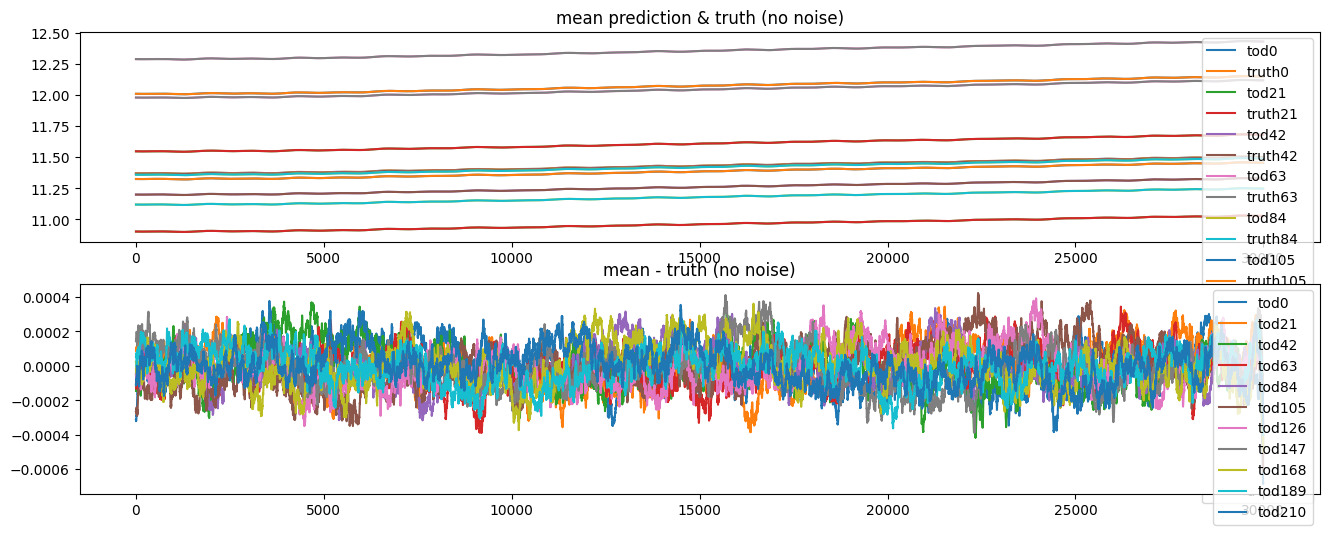

In [43]:
n_it = 10
# n_it = 30
# n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    if opt_state[0] % 2 != 0: return 
    
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    for i in range(0, n, n//10 if n//10 != 0 else 1):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i, 100:-100], label=f"truth{i}")
        # axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i, 100:-100], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

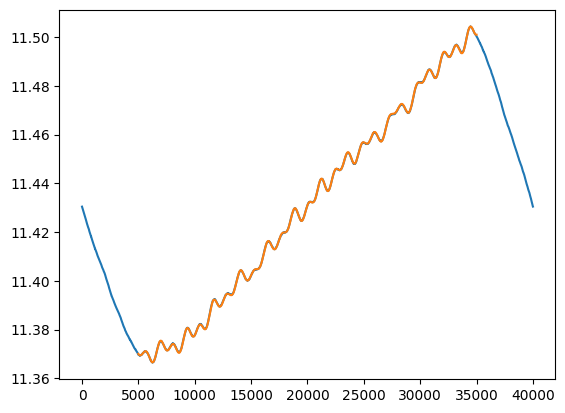

In [44]:
# offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
offset_results = offset_tod
pred = gp_tod({k: samples.pos[k] for k in samples.pos if 'comb' in k}) + offset_results[0, np.newaxis]
padded_truth = np.pad(jax_tods_atmos[0], pad_width=padding_atmos//2, mode='constant', constant_values=np.nan)

plt.plot(pred[0])
plt.plot(padded_truth)

In [45]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.002892210642743096, 0.002, 0.001
	loglogvarslope: -2.476159607198692, -2.5, 0.5
	zeromode std (LogNormal): 0.0002638700571909249, 0.0002, 0.0001


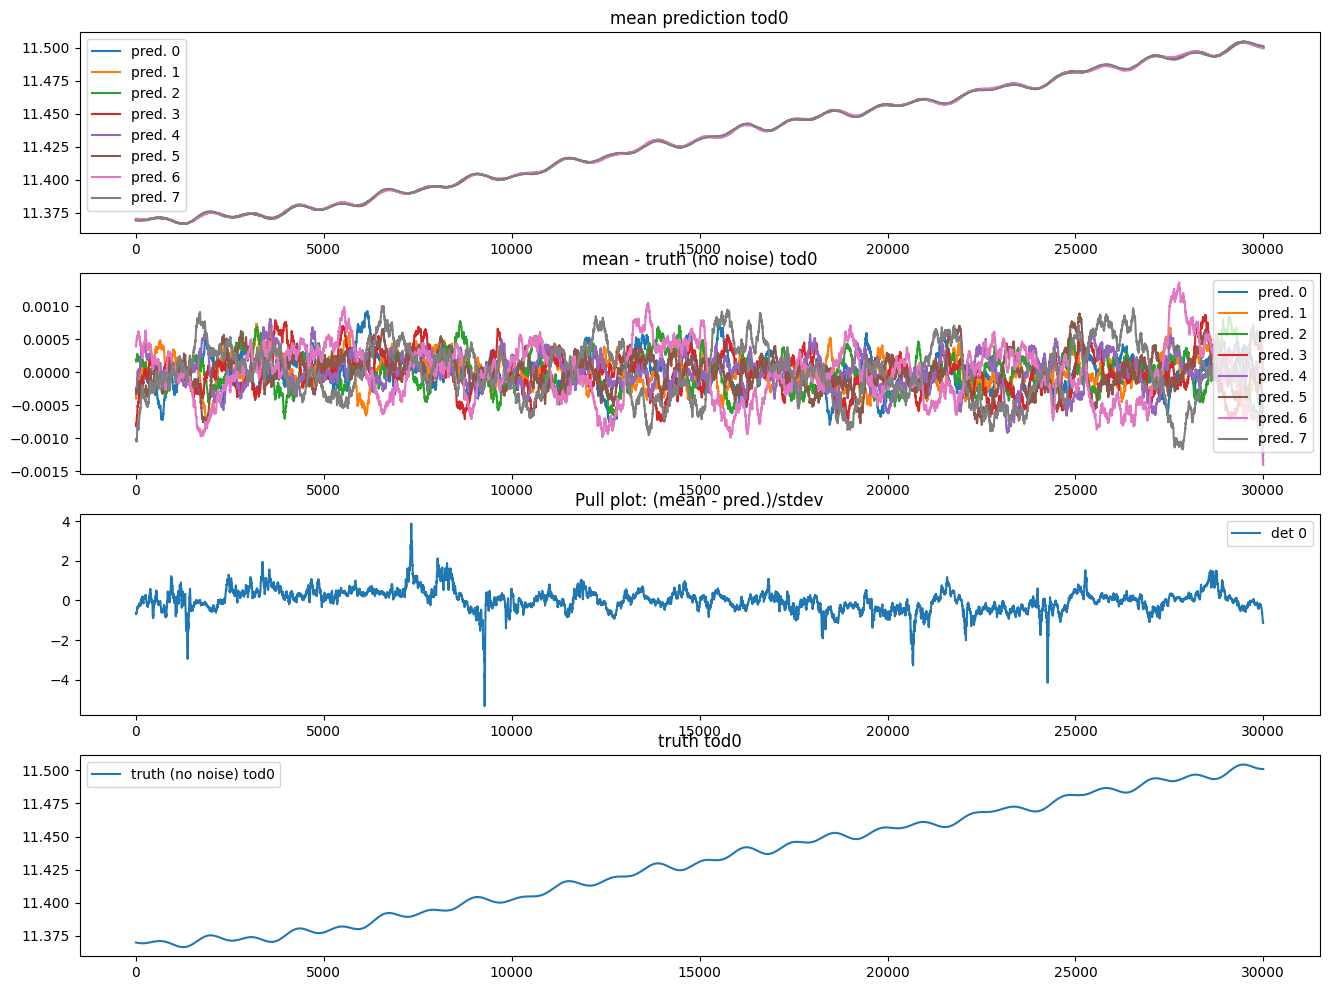

In [46]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

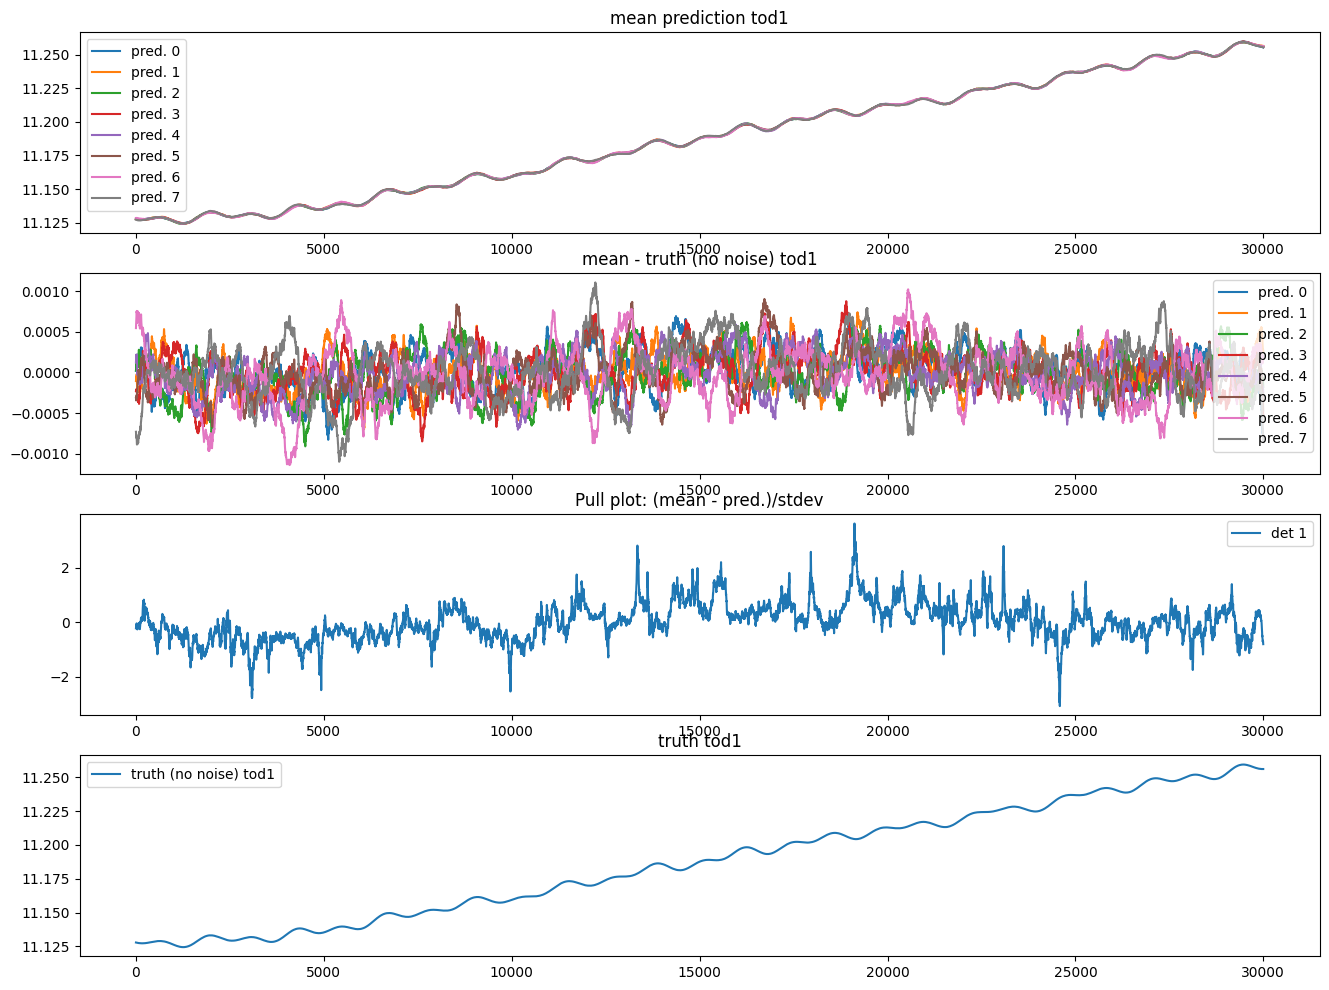

In [47]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()